In [1]:
!pip install yfinance scikit-learn matplotlib seaborn tensorflow imblearn
!conda install -c conda-forge ta-lib -y

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 875.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.1/113.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
# from tvDatafeed import tvDatafeed, Interval
# tv = TvDatafeed()
import math

In [3]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import talib

In [4]:
data = pd.read_csv('/data/notebook_files/ind_nifty200list (3).csv')
symbols = list(data.Symbol)
tickers = list(data.Symbol + '.NS')

vix_df = pd.read_csv('/data/notebook_files/indices_historical_data (1).csv')
vix_df['Date'] = pd.to_datetime(vix_df['Date'])
vix_df.index = vix_df['Date']
vix_df = vix_df.rename(columns = {'Close':'Vix_Close'})
vix_df = vix_df['Vix_Close']

In [9]:
df = yf.download(tickers[1], start = '2008-01-01', end='2023-05-01')

df1 = df.copy()
days=156                                        #Training Dataset
c=1                                             #Model Look back period 
n=25                                            #Moving Average and Z-period  

df1 = df1[['Open','Close']]

df1['Daily_ret'] = np.log(df1['Close']/df1['Close'].shift(1))

for a in range(1,6,1):
    df1['Daily_ret_lag{}'.format(a)] = df1['Daily_ret'].shift(a)     

df1['Moving_average'] = df1.Close.rolling(int(n)).mean()
df1['STD'] = df1.Close.rolling(int(n)).std()
df1['STD/Close'] = df1['STD']/df1['Close']

df1['z_score'] = (df1['Close'] - df1['Moving_average'])/df1['STD']

for b in range(1,6,1):
    df1['z_score_lag{}'.format(b)] = df1['z_score'].shift(b) 

df1['z_scoremax{}_days'.format(n)] = df1.z_score.rolling(int(n)).max()
df1['z_scoremin{}_days'.format(n)] = df1.z_score.rolling(int(n)).min()
df1['position'] = np.where((df1['z_score']<df1['z_scoremin{}_days'.format(n)].shift()) & (df1['z_score'].shift()>df1['z_scoremin{}_days'.format(n)].shift()), 1, 0)

df1['overnight_ret'] = np.log(df1['Open']/df1['Close'].shift(1))
for u in range(1,6,1):
    df1['overnight_ret_lag{}'.format(u)] = df1['overnight_ret'].shift(u)

df1['RSI']  = talib.RSI(df1['Close'], 14)
for d in range(1,6,1):
    df1['RSI_lag{}'.format(d)] = df1['RSI'].shift(d)

df1['MACD_fast'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[0]
for e in range(1,6,1):
    df1['MACD_fast_lag{}'.format(e)] = df1['MACD_fast'].shift(e)

df1['MACD_slow'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[1]
for f in range(1,6,1):
    df1['MACD_slow_lag{}'.format(f)] = df1['MACD_slow'].shift(f)
    
df1['MACD_signal'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[2]
for g in range(1,6,1):
    df1['MACD_signal_lag{}'.format(g)] = df1['MACD_signal'].shift(g)

df1 = pd.concat([df1, vix_df], axis=1)
for h in range(1,6,1):
    df1['Vix_Close_lag{}'.format(h)] = df1['Vix_Close'].shift(h)   

df1['Vix<20'] = np.where(df1['Vix_Close']<=20, 1, 0)
df1['20<Vix<30'] = np.where((df1['Vix_Close'] > 20) & (df1['Vix_Close'] < 30), 1, 0)
df1['Vix<20>30'] = np.where(df1['Vix_Close']>=30, -1, 0)

df1['direction'] = np.where(df1['overnight_ret']>0, 1, 0)
df1['direction'] = df1['direction'].shift(-1)
df1.dropna()

[*********************100%***********************]  1 of 1 completed


,Open,Close,Daily_ret,Daily_ret_lag1,Daily_ret_lag2,Daily_ret_lag3,Daily_ret_lag4,Daily_ret_lag5,Moving_average,STD,...,Vix_Close,Vix_Close_lag1,Vix_Close_lag2,Vix_Close_lag3,Vix_Close_lag4,Vix_Close_lag5,Vix<20,20<Vix<30,Vix<20>30,direction
Date,,,,,,,,,,,,,,,,,,,,,
2008-03-10,1819.000000,1908.900024,0.030828,0.011301,-0.011760,-0.010769,-0.047572,0.020275,1865.776001,58.822870,...,32.58,35.20,35.51,38.08,35.76,38.08,0,0,-1,1.0
2008-03-11,1940.000000,2000.000000,0.046620,0.030828,0.011301,-0.011760,-0.010769,-0.047572,1869.772002,64.382278,...,32.69,32.58,35.20,35.51,38.08,35.76,0,0,-1,1.0
2008-03-12,2001.000000,1865.199951,-0.069779,0.046620,0.030828,0.011301,-0.011760,-0.010769,1866.312002,62.079013,...,32.36,32.69,32.58,35.20,35.51,38.08,0,0,-1,0.0
2008-03-13,1851.000000,1844.800049,-0.010997,-0.069779,0.046620,0.030828,0.011301,-0.011760,1863.934004,61.702712,...,34.15,32.36,32.69,32.58,35.20,35.51,0,0,-1,1.0
2008-03-14,1990.000000,1815.449951,-0.016038,-0.010997,-0.069779,0.046620,0.030828,0.011301,1860.552002,61.960132,...,31.11,34.15,32.36,32.69,32.58,35.20,0,0,-1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,22400.000000,22412.949219,0.002907,-0.012449,-0.006590,-0.002699,-0.005558,0.004569,22782.743906,352.729483,...,11.67,11.63,11.94,12.15,12.08,12.27,1,0,0,0.0
2023-04-25,22382.949219,22296.199219,-0.005223,0.002907,-0.012449,-0.006590,-0.002699,-0.005558,22739.747891,343.413076,...,11.52,11.67,11.63,11.94,12.15,12.08,1,0,0,0.0
2023-04-26,22296.199219,22425.699219,0.005791,-0.005223,0.002907,-0.012449,-0.006590,-0.002699,22717.477891,345.066708,...,11.65,11.52,11.67,11.63,11.94,12.15,1,0,0,1.0


In [21]:

final_list = []

for i in range(len(tickers)):

  df = yf.download(tickers[i], start = '2008-01-01', end='2023-05-01')
  
  df1 = df.copy()
  days=156                                        #Training Dataset
  c=1                                             #Model Look back period 
  n=25                                            #Moving Average and Z-period  

  df1 = df1[['Open','Close']]

  df1['Daily_ret'] = np.log(df1['Close']/df1['Close'].shift(1))

  for a in range(1,6,1):
      df1['Daily_ret_lag{}'.format(a)] = df1['Daily_ret'].shift(a)     

  df1['Moving_average'] = df1.Close.rolling(int(n)).mean()
  df1['STD'] = df1.Close.rolling(int(n)).std()
  df1['STD/Close'] = df1['STD']/df1['Close']

  df1['z_score'] = (df1['Close'] - df1['Moving_average'])/df1['STD']

  for b in range(1,6,1):
      df1['z_score_lag{}'.format(b)] = df1['z_score'].shift(b) 

  df1['z_scoremax{}_days'.format(n)] = df1.z_score.rolling(int(n)).max()
  df1['z_scoremin{}_days'.format(n)] = df1.z_score.rolling(int(n)).min()
  df1['position'] = np.where((df1['z_score']<df1['z_scoremin{}_days'.format(n)].shift()) & (df1['z_score'].shift()>df1['z_scoremin{}_days'.format(n)].shift()), 1, 0)

  df1['overnight_ret'] = np.log(df1['Open']/df1['Close'].shift(1))
  for u in range(1,6,1):
      df1['overnight_ret_lag{}'.format(u)] = df1['overnight_ret'].shift(u)

  df1['RSI']  = talib.RSI(df1['Close'], 14)
  for d in range(1,6,1):
      df1['RSI_lag{}'.format(d)] = df1['RSI'].shift(d)

  df1['MACD_fast'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[0]
  for e in range(1,6,1):
      df1['MACD_fast_lag{}'.format(e)] = df1['MACD_fast'].shift(e)

  df1['MACD_slow'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[1]
  for f in range(1,6,1):
      df1['MACD_slow_lag{}'.format(f)] = df1['MACD_slow'].shift(f)

  df1['MACD_signal'] = talib.MACD(df1['Close'], fastperiod = 12, slowperiod = 26, signalperiod= 9)[2]
  for g in range(1,6,1):
      df1['MACD_signal_lag{}'.format(g)] = df1['MACD_signal'].shift(g)

  df1 = pd.concat([df1, vix_df], axis=1)
  for h in range(1,6,1):
      df1['Vix_Close_lag{}'.format(h)] = df1['Vix_Close'].shift(h)   

  df1['Vix<20'] = np.where(df1['Vix_Close']<=20, 1, 0)
  df1['20<Vix<30'] = np.where((df1['Vix_Close'] > 20) & (df1['Vix_Close'] < 30), 1, 0)
  df1['Vix<20>30'] = np.where(df1['Vix_Close']>=30, -1, 0)

  df1['direction'] = np.where(df1['overnight_ret']>0, 1, 0)
  df1['direction'] = df1['direction'].shift(-1)

  df1 = df1.iloc[2*n+5:]
  df1 = df1.dropna()

  df2 = df1.copy()

  X = df1.drop(columns=['direction', 'Open', 'Close', 'Moving_average', 'STD'])
  Y = df1['direction']

  smote = SMOTE(sampling_strategy = 'minority')
  X_sm, Y_sm = smote.fit_resample(X, Y)
  
  predictions = []
  probability = []

  for i in range(0, len(df2), c):

    X_train, Y_train = X_sm.iloc[i:i+days], Y_sm.iloc[i:i+days]

    Sts = StandardScaler()
    X_train_std = Sts.fit_transform(X_train)

    if X.iloc[i+days:i+days+c].shape[0] == 0:
      continue

    X_std = Sts.transform(X.iloc[i+days:i+days+c].values.reshape(-1, X.shape[1]))

    nn_model = keras.Sequential([
                                keras.layers.Dense(64, input_shape=(55,), activation='relu'),
                                keras.layers.Dense(128, activation='relu'),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(64, activation='relu'),
                                keras.layers.Dropout(0.5),
                                keras.layers.Dense(1, activation='sigmoid')
                                ])
    
    nn_model.compile(optimizer = 'adam',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
    
    history = nn_model.fit(X_train_std, Y_train, batch_size= 8, epochs = 100)

    X_pred_ar = nn_model.predict(X_std)
    X_pred = X_pred_ar.tolist()

    pred_binary = []
    for i in range(X_pred_ar.shape[0]):
      pred_binary.append(round(X_pred[i][0]))
    
    for i in pred_binary:
        predictions.append(i)

    for i in X_pred:
      probability.append(i[0])

  df1 = df1.iloc[days:]
  df1['predicted_direction'] = predictions
  df1['strategy_ret'] = df1['overnight_ret'] * df1['predicted_direction'].shift(1)
  df1['predicted_prob'] = probability


  df1 = df1.dropna()

  final_list.append(df1)

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
20/20 [==============================] - 1s 1ms/step - loss: 0.7813 - accuracy: 0.4808
Epoch 2/100
20/20 [==============================] - 0s 1ms/step - loss: 0.6953 - accuracy: 0.5321
Epoch 3/100
20/20 [==============================] - 0s 1ms/step - loss: 0.6839 - accuracy: 0.5962
Epoch 4/100
20/20 [==============================] - 0s 1ms/step - loss: 0.6864 - accuracy: 0.5833
Epoch 5/100
20/20 [==============================] - 0s 1ms/step - loss: 0.6992 - accuracy: 0.6346
Epoch 6/100
20/20 [==============================] - 0s 1ms/step - loss: 0.6999 - accuracy: 0.5641
Epoch 7/100
20/20 [==============================] - 0s 1ms/step - loss: 0.6798 - accuracy: 0.5962
Epoch 8/100
20/20 [==============================] - 0s 1ms/step - loss: 0.6382 - accuracy: 0.6795
Epoch 9/100
20/20 [==============================] - 0s 1ms/step - loss: 0.6190 - accuracy: 0.6859
Epoch 10/100
20/20 [====================

KeyboardInterrupt: KeyboardInterrupt: 

In [7]:
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
multi_position = []
overnight = []
final_prob = []

for i in final_list:

  mpdf = i.loc[:,'predicted_direction']
  multi_position.append(mpdf)
  
  ovrn_ret = i.loc[:,'Daily_ret']        #overnight_ret
  overnight.append(ovrn_ret)

  probab = i.loc[:,'predicted_prob']
  final_prob.append(probab)

multi_position_df = pd.DataFrame(multi_position).T.shift()
multi_position_df.columns = symbols
  
overnight_df = pd.DataFrame(overnight).T
overnight_df.columns = symbols

final_prob_df = pd.DataFrame(final_prob).T.shift()
final_prob_df.columns = symbols

stocks_trade = []

for i in range(len(final_prob_df)):
    sorted_probabilities = final_prob_df.iloc[i]
    sorted_probabilities = sorted_probabilities[sorted_probabilities>0.50]
    sorted_probabilities = sorted_probabilities.sort_values(ascending=False).nlargest(10)
    sorted_columns = sorted_probabilities.index.tolist()
    stocks_trade.append(sorted_columns)

portfolio_returns = []

for i in range(len(stocks_trade)):
    sret = overnight_df.loc[:, stocks_trade[i]] * multi_position_df.loc[:, stocks_trade[i]]
    sret = sret.iloc[i].mean()
    portfolio_returns.append(sret)

strategy_returns = pd.DataFrame(portfolio_returns, columns = ['Returns'])
strategy_returns.index = overnight_df.index
strategy_returns['Strategy_Nav'] = strategy_returns['Returns'].cumsum().apply(np.exp)
strategy_returns['cum_max'] = strategy_returns['Strategy_Nav'].cummax()
strategy_returns['drawdown'] = 100* (strategy_returns['Strategy_Nav'] - strategy_returns['cum_max']) / strategy_returns['cum_max']

strategy_returns['Returns_after_tc'] = strategy_returns['Returns'] + np.log(0.999)
strategy_returns['Strategy_Nav_after_tc'] = strategy_returns['Returns_after_tc'].cumsum().apply(np.exp)
strategy_returns['cum_max_after_tc'] = strategy_returns['Strategy_Nav_after_tc'].cummax()
strategy_returns['drawdown_adter_tc'] = 100* (strategy_returns['Strategy_Nav_after_tc'] - strategy_returns['cum_max_after_tc']) / strategy_returns['cum_max_after_tc']

In [13]:
nifty = yf.download('^NSEI', start = '2013-02-01').Close

[*********************100%***********************]  1 of 1 completed


In [14]:
nifty['Strategy_Nav'] = pd.DataFrame(np.log(nifty/nifty.shift()).cumsum().apply(np.exp))
nifty['cum_max'] = nifty['Strategy_Nav'].cummax()
nifty['drawdown'] = 100* (nifty['Strategy_Nav'] - nifty['cum_max']) / nifty['cum_max']

In [16]:
tt = []
for i in stocks_trade:
    tt.append(len(i))
tt = pd.DataFrame(tt, index = final_prob_df.index).iloc[2:]

TypeError: TypeError: object of type 'int' has no len()

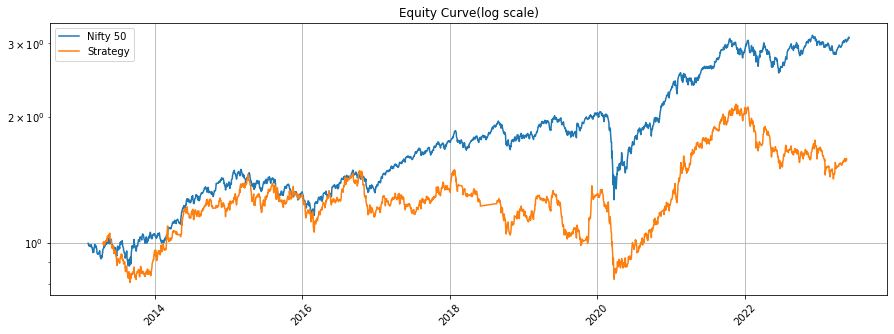

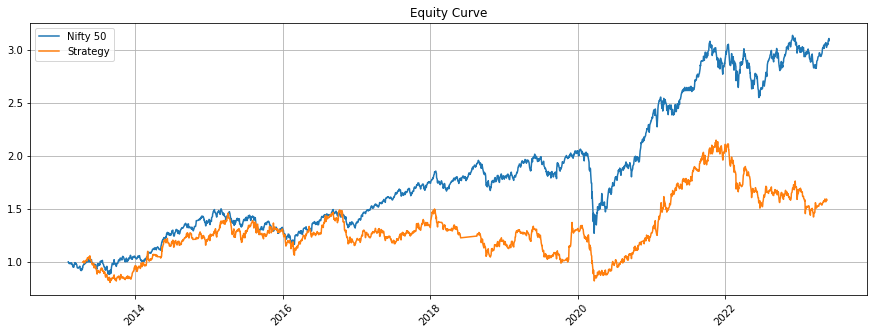

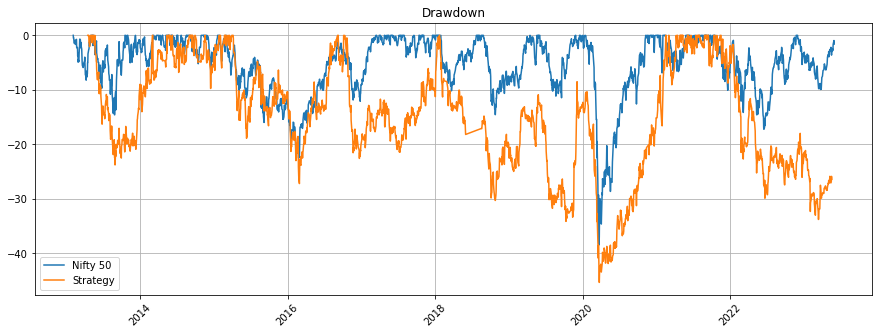

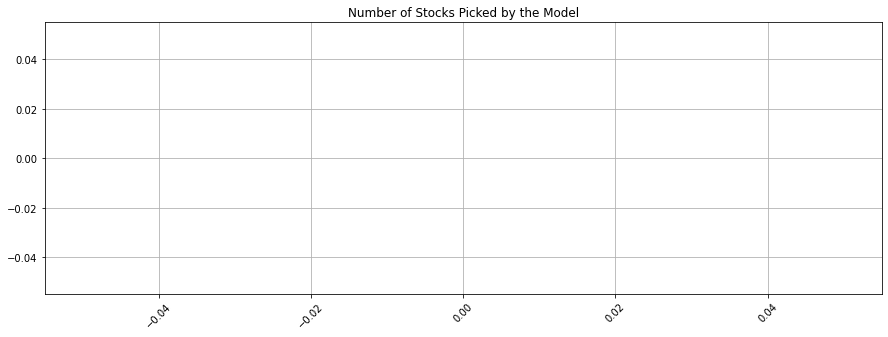

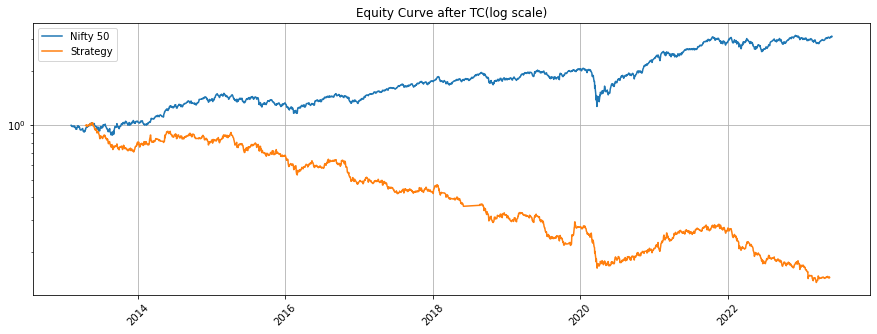

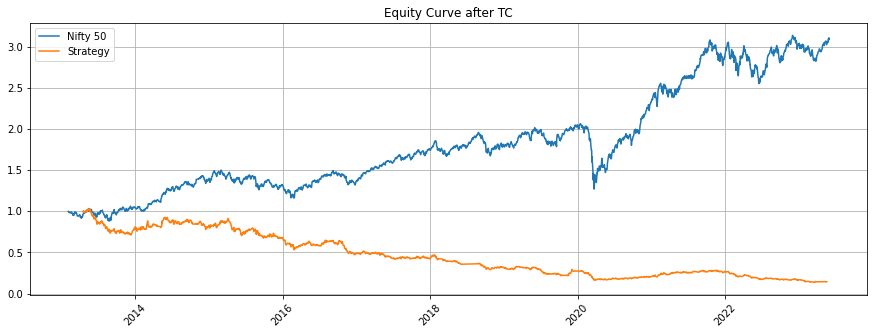

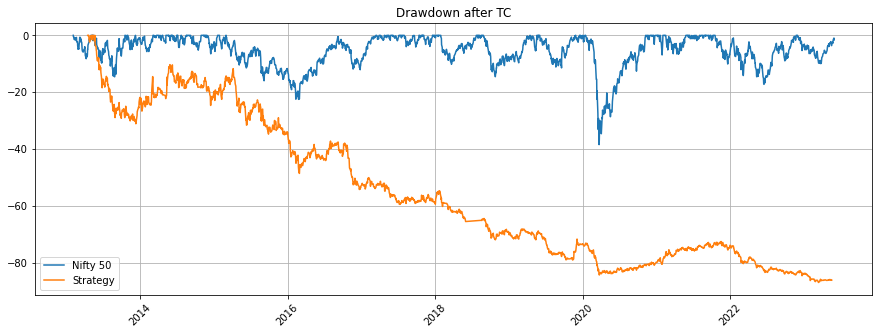

In [66]:
plt.figure(figsize=(15,5))
plt.grid()
plt.yscale('log')
plt.xticks(rotation = 45)
plt.title('Equity Curve(log scale)')
plt.plot(nifty['Strategy_Nav'], label = 'Nifty 50')
plt.plot(strategy_returns['Strategy_Nav'], label = 'Strategy')
plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.grid()
plt.xticks(rotation = 45)
plt.title('Equity Curve')
plt.plot(nifty['Strategy_Nav'], label = 'Nifty 50')
plt.plot(strategy_returns['Strategy_Nav'], label = 'Strategy')
plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.grid()
plt.xticks(rotation = 45)
plt.title('Drawdown')
plt.plot(nifty['drawdown'], label = 'Nifty 50')
plt.plot(strategy_returns['drawdown'], label = 'Strategy')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.grid()
plt.xticks(rotation = 45)
plt.title('Number of Stocks Picked by the Model')
plt.plot(tt)

plt.figure(figsize=(15,5))
plt.grid()
plt.yscale('log')
plt.xticks(rotation = 45)
plt.title('Equity Curve after TC(log scale)')
plt.plot(nifty['Strategy_Nav'], label = 'Nifty 50')
plt.plot(strategy_returns['Strategy_Nav_after_tc'], label = 'Strategy')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.grid()
plt.xticks(rotation = 45)
plt.title('Equity Curve after TC')
plt.plot(nifty['Strategy_Nav'], label = 'Nifty 50')
plt.plot(strategy_returns['Strategy_Nav_after_tc'], label = 'Strategy')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.grid()
plt.xticks(rotation = 45)
plt.title('Drawdown after TC')
plt.plot(nifty['drawdown'], label = 'Nifty 50')
plt.plot(strategy_returns['drawdown_adter_tc'], label = 'Strategy')
plt.legend()
plt.show()

In [11]:
stocks_trade_df = pd.DataFrame(stocks_trade)
stocks_trade_df.index = final_prob_df.index
stocks_trade_df.to_csv('stocks_data.csv', index = True)

NameError: NameError: name 'stocks_trade' is not defined

In [30]:
import pickle

# Save the list to a fileS
with open('nifty500finaldata.pkl', 'wb') as f:
    pickle.dump(final_list, f)

In [60]:
import pickle

# Read the pickled list from the file
with open('list.pkl', 'rb') as f:
    final_list = pickle.load(f)

In [61]:
for i in final_list:
    i['10_ma'] = i['Close'].rolling(10).mean()       #best at 30
    i.dropna(inplace = True)

In [62]:
multi_position = []
dailyret = []
final_prob = []
ma10 = []
close = []

for i in final_list:

  mpdf = i.loc[:,'predicted_direction']
  multi_position.append(mpdf)
  
  d_ret = i.loc[:,'Daily_ret']
  dailyret.append(d_ret)

  probab = i.loc[:,'predicted_prob']
  final_prob.append(probab)
    
  ma = i.loc[:,'10_ma']
  ma10.append(ma)
    
  cl = i.loc[:,'Close']
  close.append(cl)

multi_position_df = pd.DataFrame(multi_position).T.shift()
multi_position_df.columns = symbols
  
dailyret_df = pd.DataFrame(dailyret).T
dailyret_df.columns = symbols

final_prob_df = pd.DataFrame(final_prob).T.shift()
final_prob_df.columns = symbols

ma_df = pd.DataFrame(ma10).T
ma_df.columns = symbols

close_df = pd.DataFrame(close).T
close_df.columns = symbols

In [63]:
stocks_trade = []
Number_of_stocks = 5

for i in range(len(final_prob_df)):
    sorted_probabilities = final_prob_df.iloc[i]
    sorted_probabilities = sorted_probabilities[sorted_probabilities>0.50]
    sorted_probabilities = sorted_probabilities.sort_values(ascending=False).nlargest(Number_of_stocks)
    sorted_columns = sorted_probabilities.index.tolist()
    stocks_trade.append(sorted_columns)

stocks_trade = pd.DataFrame(stocks_trade, index =final_prob_df.index)

In [64]:
for j in range(Number_of_stocks):
    for i in range(3, len(stocks_trade)):
        if close_df.loc[stocks_trade.index[i-1],stocks_trade.iloc[i-1]][j] > ma_df.loc[stocks_trade.index[i-1],stocks_trade.iloc[i-1]][j]: 
            stocks_trade.iloc[i,j] = stocks_trade.iloc[i-1,j]
        else:
            pass

In [65]:
portfolio_returns = []

for i in range(2,len(stocks_trade)):
    sret = dailyret_df.loc[:, stocks_trade.iloc[i]] * multi_position_df.loc[:, stocks_trade.iloc[i]]
    sret = sret.iloc[i].mean()
    portfolio_returns.append(sret)

strategy_returns = pd.DataFrame(portfolio_returns, columns = ['Returns'])
strategy_returns.index = dailyret_df[2:].index
strategy_returns['Strategy_Nav'] = strategy_returns['Returns'].cumsum().apply(np.exp)
strategy_returns['cum_max'] = strategy_returns['Strategy_Nav'].cummax()
strategy_returns['drawdown'] = 100* (strategy_returns['Strategy_Nav'] - strategy_returns['cum_max']) / strategy_returns['cum_max']

strategy_returns['Returns_after_tc'] = strategy_returns['Returns'] + np.log(0.999)
strategy_returns['Strategy_Nav_after_tc'] = strategy_returns['Returns_after_tc'].cumsum().apply(np.exp)
strategy_returns['cum_max_after_tc'] = strategy_returns['Strategy_Nav_after_tc'].cummax()
strategy_returns['drawdown_adter_tc'] = 100* (strategy_returns['Strategy_Nav_after_tc'] - strategy_returns['cum_max_after_tc']) / strategy_returns['cum_max_after_tc']

In [11]:
strategy_returns

,Returns,Strategy_Nav,cum_max,drawdown,Returns_after_tc,Strategy_Nav_after_tc,cum_max_after_tc,drawdown_adter_tc
Date,,,,,,,,
2013-05-06,0.011007,1.011067,1.011067,0.000000,0.010006,1.010056,1.010056,0.000000
2013-05-07,0.005894,1.017044,1.017044,0.000000,0.004893,1.015011,1.015011,0.000000
2013-05-08,0.002332,1.019418,1.019418,0.000000,0.001331,1.016363,1.016363,0.000000
2013-05-09,-0.006098,1.013221,1.019418,-0.607930,-0.007098,1.009174,1.016363,-0.707322
2013-05-10,-0.000975,1.012233,1.019418,-0.704827,-0.001976,1.007182,1.016363,-0.903318
...,...,...,...,...,...,...,...,...
2023-05-15,-0.004789,1.539165,2.201185,-30.075612,-0.005790,0.142139,1.040907,-86.344707
2023-05-16,0.002609,1.543187,2.201185,-29.892916,0.001609,0.142368,1.040907,-86.322720
2023-05-17,0.001550,1.545580,2.201185,-29.784194,0.000549,0.142446,1.040907,-86.315208
